# Classifier für Wohnungsbilder

## Simple CNN

### Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np

from sklearn.metrics import confusion_matrix
from keras.utils.vis_utils import model_to_dot

import tensorflow as tf
tf.set_random_seed(1)

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

import os
print ("Keras {} TF {} Python {}".format(keras.__version__, tf.__version__, sys.version_info))

Using TensorFlow backend.


NameError: name 'keras' is not defined

### Image Preprocessing

In [2]:
def create_datagens(img_width, img_height, batch_size, train_dir, valid_dir):
    # Data Generators
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    valid_datagen = ImageDataGenerator(
        rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size = batch_size)

    valid_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)
    
    return train_generator, valid_generator

### Network Layout

In [49]:
def define_network(img_width, img_height):
    
    model = Sequential()
    name = "VGG16_finetuning"
    
    # load VGG16 model
    from keras.applications.vgg16 import VGG16
    model.add(VGG16(weights = "imagenet", 
                    include_top = False, 
                    input_shape = (img_width, img_height, 3)))
    
    # add top layers)
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    
    model.add(Dense(64))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    
    model.add(Dense(6))
    model.add(Activation("softmax"))
    
    # freeze bottom layers
    model.layers[0].trainable = False
    
    # compile model
    model.compile(optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"])
    
    return model, name

### Training

In [50]:
# parameters
img_width = 224
img_height = 224

train_dir = "data/clean/train/"
valid_dir = "data/clean/valid/"
test_dir = "data/clean/test/"

batch_size = 32
epochs = 10

n_train = len(os.listdir(train_dir))
n_valid = len(os.listdir(valid_dir))

# preprocessing
train_generator, valid_generator = create_datagens(img_width, img_height, batch_size, train_dir, valid_dir)

# network layout
model, name = define_network(img_width, img_height)

model.summary()

Found 1465 images belonging to 6 classes.
Found 264 images belonging to 6 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_13 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               6422784   
_________________________________________________________________
activation_26 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               32896     
___________________________________________________________

In [51]:
# setup tensorboard
from keras.callbacks import TensorBoard, ModelCheckpoint

tensorboard = TensorBoard(
        log_dir='tensorboard/' + name + '/', 
        write_graph=True,
        histogram_freq=0)

#save model after every 10 epochs 
savedir = "checkpoints/"+name+"/"
os.makedirs(savedir,exist_ok=True)       
checkpointer = ModelCheckpoint( 
        filepath =  savedir+"weights_epoch_{epoch:03d}-{val_loss:.2f}.hdf5",
        verbose = 1, 
        save_best_only = False,
        period = 5 )

In [52]:
# run training
history = model.fit_generator(
    generator=train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    callbacks = [tensorboard, checkpointer])

Epoch 1/10
14/46 [========>.....................] - ETA: 11:02 - loss: 8.3676 - acc: 0.2388

KeyboardInterrupt: 

### Evaluation

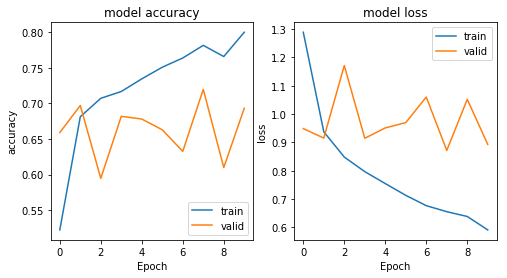

In [39]:
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()